In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from functools import reduce
import scipy
from copy import deepcopy
from scipy.linalg import logm
import numpy as np
import dill


In [59]:
import dill 
num_keep = 500
filename = 'pickled_controls5.pkl'
pca = dill.load(open(filename, 'rb'))
pca.controlset = pca.controlset[:num_keep]

In [60]:
def hist_and_support(weights, num=10):
    plt.hist(weights)
    np.argmax(weights)
    top_idx = np.argsort(np.array(weights).T)[0][-num:]
    top_values = [weights[i] for i in top_idx]
    print(f"SUPPORT:{np.sum(top_values)}")
    print(f"NUM CONTROLS: {num}")
    return top_idx, np.sum(top_values)

In [61]:
num_weights = 10
scale = 100
num_points = 11
num_processors = 4

In [63]:
from convex import all_derivs, optimal_weights_1st_order, optimal_weights
from pauli_channel_approximation import PCA
# If the tolerance is too high (i.e. not zero) and the number of controls is too high (e.g. >100) this was failing with ECOS.
pca.derivs = all_derivs(pca.controlset, pca.target_operator, pca.control_hamiltonians, pca.ambient_hamiltonian, pca.dt, 1)

# Making the regularizer too small can prevent it from working - i.e. the solver will fail. Anything above around 1E-3 or 1E-4 seems to work well. These cells assign the 0RBC weights, and 1RBC weights, with sparsity constraints. (This could be because the constraint makes the optimization work over numbers small in magnitude, so that numerical inaccuracy takes over.)

# Support for 0th order controls

In [65]:
# MAX_TO_SUPPORT_RATIO = 1
# def cost_function(l, pca):
#     try:
#         PCA.assign_weights_0(pca, l)
#         indices, support = hist_and_support(pca.weights_0)
#         plt.show()
#         plt.clf()
#         maximum = max(pca.weights_0[indices])
#         rtn = (maximum*MAX_TO_SUPPORT_RATIO + (1 - support))
#         print(f"cost function: {rtn}")
#         print(f"Evaluated with l={l}")
#     except TypeError:
#         rtn = MAX_TO_SUPPORT_RATIO + 1
#     return rtn

In [66]:
# from scipy.optimize import minimize

# THRESHOLD_SUPPORT = .9
# THRESHOLD_MAXIMUM = .5

# def find_l(pca, l0=1E-6): #initial guess is l0
#     l = minimize(lambda l: cost_function(l, pca), x0=l0)
#     return l

In [67]:
# l = find_l(pca)

In [68]:
# cost_function(l.x, pca)

In [69]:
PCA.assign_weights(pca, 0, 1e-3)

Done with convex problem 0 out of 500
Done with convex problem 10 out of 500
Done with convex problem 20 out of 500
Done with convex problem 30 out of 500
Done with convex problem 40 out of 500
Done with convex problem 50 out of 500
Done with convex problem 60 out of 500
Done with convex problem 70 out of 500
Done with convex problem 80 out of 500
Done with convex problem 90 out of 500
Done with convex problem 100 out of 500
Done with convex problem 110 out of 500
Done with convex problem 120 out of 500
Done with convex problem 130 out of 500
Done with convex problem 140 out of 500
Done with convex problem 150 out of 500
Done with convex problem 160 out of 500
Done with convex problem 170 out of 500
Done with convex problem 180 out of 500
Done with convex problem 190 out of 500
Done with convex problem 200 out of 500
Done with convex problem 210 out of 500
Done with convex problem 220 out of 500
Done with convex problem 230 out of 500
Done with convex problem 240 out of 500
Done with c

SUPPORT:0.9999998111271474
NUM CONTROLS: 10


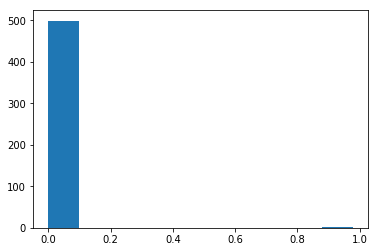

In [70]:
import matplotlib.pyplot as plt
indices0, _ = hist_and_support(pca.weights_0, 10)

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
pca0 = dill.load(open(filename, 'rb'))
subweights = pca.weights_0[indices0]
pca0.controlset = [pca0.controlset[i] for i in indices0]
pca0.probs = list(np.array(subweights.T/sum(subweights)).T)

# Support for 1st order controls

In [15]:
# def cost_function(l, pca):
#     try:
#         PCA.assign_weights(pca, l)
#         indices, support = hist_and_support(pca.weights)
#         plt.show()
#         maximum = max(pca.weights[indices])
#         rtn = (maximum*MAX_TO_SUPPORT_RATIO + (1 - support))
#         print(f"cost function: {rtn}")
#         print(f"Evaluated with l={l}")
#     except TypeError:
#         rtn = MAX_TO_SUPPORT_RATIO + 1
#     return rtn

In [16]:
# l = find_l(pca, l0=1E-5)

SUPPORT:1.000000451611253
NUM CONTROLS: 10


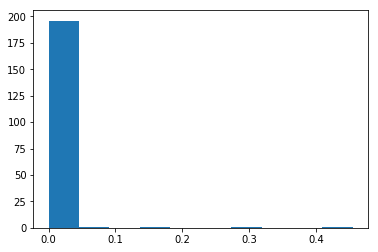

In [17]:
# Consider setting minimizer tolerance
#PCA.assign_weights(pca, 1E-5)
indices1, _ = hist_and_support(pca.weights)

In [19]:
pca1 = dill.load(open(filename, 'rb'))
subweights = pca.weights[indices1]
pca1.controlset = [pca1.controlset[i] for i in indices1]
pca1.probs = list(np.array(subweights.T/sum(subweights)).T)

In [20]:
# Save the weighted controls

import dill
dill.dump(pca0, open('0_' + filename, 'wb'))

import dill
dill.dump(pca1, open('1_' + filename, 'wb'))

# Diamond Norm

In [34]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [35]:
from ipyparallel import Client
rc = Client(profile='mpi3')
dc = rc[:]

/home/anthony/.pyenv/versions/3.6.3/envs/personal/lib/python3.6/site-packages/ipyparallel/client/client.py:459: RuntimeWarning: 
            Controller appears to be listening on localhost, but not on this machine.
            If this is true, you should specify Client(...,sshserver='you@GLaDOS')
            or instruct your controller to listen on an external IP.
  RuntimeWarning)


In [36]:
import os
dc.push({'cwd':os.getcwd()})

<AsyncResult: _push>

In [38]:
%%px
import os
os.chdir(cwd)

In [39]:
%%px
import dill
import itertools
import numpy as np
from pauli_channel_approximation import compute_dpn_and_fid
import matplotlib.pyplot as plt
from itertools import product

In [40]:
%%px 
from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()

In [41]:
%%px
filename = 'pickled_controls5.pkl'
pca0 = dill.load(open('0_' + filename, 'rb')) # 0RBC
pca1 = dill.load(open('1_' + filename, 'rb')) # 1RBC

# Diamond Norm

In [42]:
%%px
import sys
import itertools
from itertools import product
from copy import deepcopy
from functools import reduce

from diamond import diamond_norm, jamiolkowski

def superoperator(unitary):

    return np.kron(unitary.conj(), unitary)

def choi_form(unitary):

    return jamiolkowski(superoperator(unitary))

def diamond_distance(unitary_a,unitary_b):
    return diamond_norm(choi_form(unitary_a) - choi_form(unitary_b))/2.

def compute_diamond_norm(data):
    controlset, ambient_hamiltonian0, combo, dt, control_hamiltonians, target_operator, probs = data
    print("DOING COMBO {}".format(combo))
    sys.stdout.flush()
    fidelities = []
    projs = []
    sops = []
    controlset_unitaries = []
    d_norms = []

    for controls in controlset:
        newcontrols = deepcopy(controls)
        ambient_hamiltonian = [deepcopy(ah).astype("complex") for ah in ambient_hamiltonian0]
        for cnum, value in enumerate(combo):
            cnum -= len(ambient_hamiltonian0)
            if cnum >= 0:
                newcontrols[:, cnum] = newcontrols[:, cnum] * (1 + value)
            if cnum < 0:
                ambient_hamiltonian[cnum] *= float(value)
        step_unitaries = control_unitaries(ambient_hamiltonian,
                                           control_hamiltonians, newcontrols,
                                           dt)
        unitary = reduce(lambda a, b: a.dot(b), step_unitaries)
        sop = error_unitary(unitary, target_operator)
        sops.append(sop)
        d_norms.append(diamond_distance(sop, np.eye(sop.shape[0])))
    avg_sop = reduce(lambda a, b: a + b, [prob * sops[i] for i, prob in enumerate(probs)])
    d_norms.append(diamond_distance(avg_sop, np.eye(avg_sop.shape[0])))
    return d_norms

In [43]:
num_pts = 7

In [44]:
%%px
num_pts = 7
#pca0 and pca1 should have the same detunings, so we just use pca0 here.
base = np.logspace(-4.7, np.log(pca0.detunings[0][0])/np.log(10), (num_pts - 1)/2)
controls = np.concatenate([np.sort(-base),np.array([0]), base])
combinations0 = [[det,0] for det in controls]

base = np.logspace(-4.7, np.log(pca0.detunings[1][0])/np.log(10), (num_pts - 1)/2)
controls = np.concatenate([np.sort(-base),np.array([0]), base])
combinations1 = [[0,det] for det in controls]

In [45]:
%%px
from pauli_channel_approximation import control_unitaries, error_unitary
def dnorms(pca):
    try:
        combo = combinations0[rank]
        lst = [pca0.controlset, pca.ambient_hamiltonian, combo, pca.dt,
                pca.control_hamiltonians, pca.target_operator, pca.probs]
        d_norms0 = compute_diamond_norm(lst)

        combo = combinations1[rank]
        lst = [pca.controlset, pca.ambient_hamiltonian, combo, pca.dt,
                pca.control_hamiltonians, pca.target_operator, pca.probs]
        d_norms1 = compute_diamond_norm(lst)
    except IndexError:
        pass
    return d_norms0, d_norms1

# 0RBC

In [46]:
%%px
combo = combinations0[rank]
d_norms00, d_norms01 = dnorms(pca0)

[stdout:0] 
DOING COMBO [-0.001000000000000001, 0]
DOING COMBO [0, -0.001000000000000001]
[stdout:1] 
DOING COMBO [-0.00014125375446227554, 0]
DOING COMBO [0, -0.00014125375446227554]
[stdout:2] 
DOING COMBO [-1.9952623149688786e-05, 0]
DOING COMBO [0, -1.9952623149688786e-05]
[stdout:3] 
DOING COMBO [0.0, 0]
DOING COMBO [0, 0.0]
[stdout:4] 
DOING COMBO [1.9952623149688786e-05, 0]
DOING COMBO [0, 1.9952623149688786e-05]
[stdout:5] 
DOING COMBO [0.00014125375446227554, 0]
DOING COMBO [0, 0.00014125375446227554]
[stdout:6] 
DOING COMBO [0.001000000000000001, 0]
DOING COMBO [0, 0.001000000000000001]


# 1RBC

In [51]:
%%px
d_norms10, d_norms11 = dnorms(pca1)

[stdout:0] 
DOING COMBO [-0.001000000000000001, 0]
DOING COMBO [0, -0.001000000000000001]
[stdout:1] 
DOING COMBO [-0.00014125375446227554, 0]
DOING COMBO [0, -0.00014125375446227554]
[stdout:2] 
DOING COMBO [-1.9952623149688786e-05, 0]
DOING COMBO [0, -1.9952623149688786e-05]
[stdout:3] 
DOING COMBO [0.0, 0]
DOING COMBO [0, 0.0]
[stdout:4] 
DOING COMBO [1.9952623149688786e-05, 0]
DOING COMBO [0, 1.9952623149688786e-05]
[stdout:5] 
DOING COMBO [0.00014125375446227554, 0]
DOING COMBO [0, 0.00014125375446227554]
[stdout:6] 
DOING COMBO [0.001000000000000001, 0]
DOING COMBO [0, 0.001000000000000001]


In [52]:
controls = np.array([rc[i]['combo'][0] for i in range(num_pts)])

In [53]:
diamond_norms00 = np.array([rc[i]['d_norms00'] for i in range(num_pts)])
diamond_norms01 = np.array([rc[i]['d_norms01'] for i in range(num_pts)])

In [54]:
diamond_norms10 = np.array([rc[i]['d_norms10'] for i in range(num_pts)])
diamond_norms11 = np.array([rc[i]['d_norms11'] for i in range(num_pts)])

# If we don't include enough controls (say 20) the two plots will look similar. Need more controls for more diversity in the solutions.

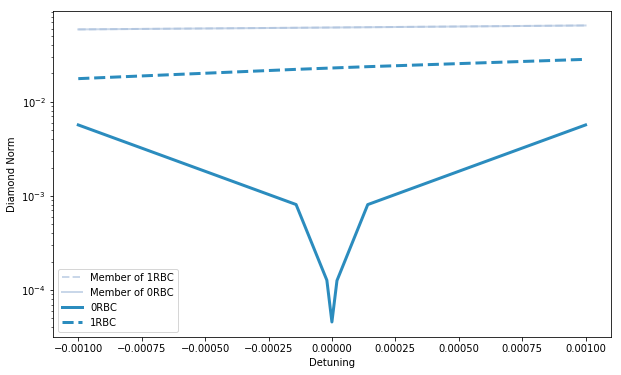

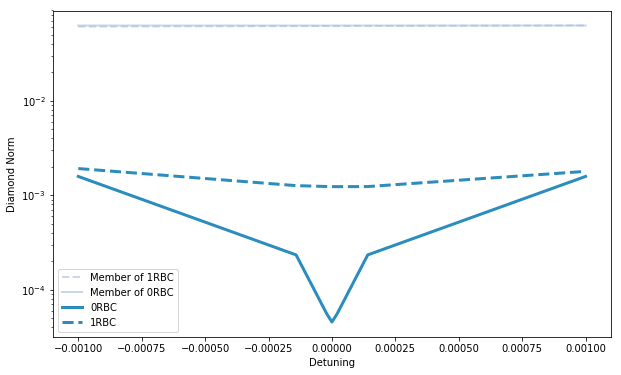

In [58]:
for a, b in ((diamond_norms00, diamond_norms10), (diamond_norms01, diamond_norms11)):
    plt.figure(figsize=(10,6))
    plt.semilogy(controls, np.array(a).T[7], linewidth = 2, alpha=.6, color='#a6bddb', label="Member of 0RBC", ls="--");
    plt.semilogy(controls, np.array(b).T[7], linewidth = 2, alpha=.6, color='#a6bddb', label="Member of 1RBC", ls="-");


    plt.semilogy(controls, np.array(a).T[-1], linewidth = 3, alpha=1, color='#2b8cbe', label="0RBC", ls="-");
    plt.semilogy(controls,np.array(b).T[-1], linewidth = 3, alpha=1, color='#2b8cbe', label="1RBC", ls="--");
    plt.ylabel("Diamond Norm")
    plt.xlabel("Detuning")
    plt.legend()

In [ ]:
for i, row in enumerate(d_norms[:-1, :]):
    reordered_row = np.array([row[j] for j in indices])
    plt.plot(range(len(row)), reordered_row)
plt.plot(range(len(d_norms[-1, :])), [d_norms[-1, :][i] for i in indices], label="min", color='k', linewidth=2, zorder=10)
plt.legend()
plt.ylabel("Diamond Distance")
plt.semilogy()
plt.xlabel("Sample Index")
plt.tight_layout()
plt.show()


In [ ]:
for i, row in enumerate(d_norms[:-1, :]):
    reordered_row = np.array([row[j] for j in indices])
    plt.plot(range(len(row)), reordered_row)
plt.plot(range(len(d_norms[-1, :])), [d_norms[-1, :][i] for i in indices], label="min", color='k', linewidth=2, zorder=10)
plt.legend()
plt.ylabel("Diamond Distance")
plt.semilogy()
plt.xlabel("Sample Index")
plt.tight_layout()
plt.show()


In [15]:
import warnings
warnings.filterwarnings("ignore")

In [16]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
sns.set_style('white')

In [16]:
import dill
import itertools
import numpy as np
from pauli_channel_approximation import compute_dpn_and_fid
import matplotlib.pyplot as plt
from itertools import product

In [18]:
from pauli_channel_approximation import control_unitaries, error_unitary, off_diagonal_projection, adjoint
import sys
import itertools
from itertools import product
from copy import deepcopy
from functools import reduce

from diamond import diamond_norm, jamiolkowski

def superoperator(unitary):

    return np.kron(unitary.conj(), unitary)

def choi_form(unitary):

    return jamiolkowski(superoperator(unitary))

def diamond_distance(unitary_a,unitary_b):
    return diamond_norm(choi_form(unitary_a) - choi_form(unitary_b))/2.

def compute_diamond_norm(data):
    controlset, ambient_hamiltonian0, combo, dt, control_hamiltonians, target_operator, probs = data
#     print("DOING COMBO {}".format(combo))
#     sys.stdout.flush()
    fidelities = []
    projs = []
    sops = []
    controlset_unitaries = []
    d_norms = []
    #
    #
    # for i, com in enumerate(combo):
    #     if i != 0 and com != 0:
    #         return 0
    for cind, controls in enumerate(controlset):
        newcontrols = deepcopy(controls)
        ambient_hamiltonian = [deepcopy(ah).astype("float") for ah in ambient_hamiltonian0]
        for cnum, value in enumerate(combo):
            cnum -= len(ambient_hamiltonian0)
            if cnum >= 0:
                newcontrols[:, cnum] = newcontrols[:, cnum] * (1 + value)
            if cnum < 0:
                ambient_hamiltonian[cnum] *= float(value)
        step_unitaries = control_unitaries(ambient_hamiltonian,
                                           control_hamiltonians, newcontrols,
                                           dt)
        unitary = reduce(lambda a, b: a.dot(b), step_unitaries)
        sop = error_unitary(unitary, target_operator)
        sops.append(sop)
        ddist = diamond_distance(sop, np.eye(sop.shape[0]))
        with open('./data/{}.out'.format(rank), 'a+') as f:
            f.write("{}\t{}\t{}\n".format(cind,combo,ddist))
        d_norms.append(ddist)
    avg_sop = reduce(lambda a, b: a + b, [prob * sops[i] for i, prob in enumerate(probs)])
    ddist = diamond_distance(avg_sop, np.eye(avg_sop.shape[0]))
    with open('./data/{}.out'.format(rank), 'a+') as f:
            f.write("{}\t{}\t{}\n".format("avg",combo,ddist))
    d_norms.append(ddist)

    return d_norms

def generate_indices(num_points, order_desired):
    num_indices = len(order_desired)
    tuples = product(range(num_points), repeat=num_indices)
    indices = [sum([num_points**(num_indices - 1 - order_desired[i]) * t[i] 
                    for i in range(num_indices)]) for t in tuples]
    return indices

In [19]:
sigI = np.array([[1.,0],[0, 1]], dtype='complex')
sigX = np.array([[0, 1],[1, 0]], dtype='complex')
sigY = np.array([[0,-1],[1, 0]], dtype='complex') * 1.j
sigZ = np.array([[1, 0],[0,-1]], dtype='complex')
sigM = (sigX - 1.j*sigY)/2.
sigP = (sigX + 1.j*sigY)/2.
diamond_distance(sigX,sigY)

0.9999999953656783

In [20]:
pca = pca1

In [43]:
num_pts = 10
base = np.logspace(-4.7, np.log(pca.detunings[0][0])/np.log(10), num_pts)
controls = np.concatenate([np.sort(-base),np.array([0]), base])
combinations0 = [[det,0] for det in controls]

base = np.logspace(-4.7, np.log(pca.detunings[1][0])/np.log(10), num_pts)
controls = np.concatenate([np.sort(-base),np.array([0]), base])
combinations1 = [[0,det] for det in controls]

d_norms0 = []
for i in range(len(combinations0)):
    combo = combinations0[i]
    lst = [pca.controlset, pca.ambient_hamiltonian, combo, pca.dt,
            pca.control_hamiltonians, pca.target_operator, pca.probs]
    d_norms0.append(compute_diamond_norm(lst))

d_norms1 = []
for i in range(len(combinations1)):
    combo = combinations1[i]
    lst = [pca.controlset, pca.ambient_hamiltonian, combo, pca.dt,
            pca.control_hamiltonians, pca.target_operator, pca.probs]
    d_norms1.append(compute_diamond_norm(lst))


In [47]:
# diamond_norms = np.array([rc[i]['d_norms'] for i in range(20)])
# controls = np.array([rc[i]['combo'][0] for i in range(20)])
#diamond_norms = np.array(d_norms0)
controls = np.array(controls)

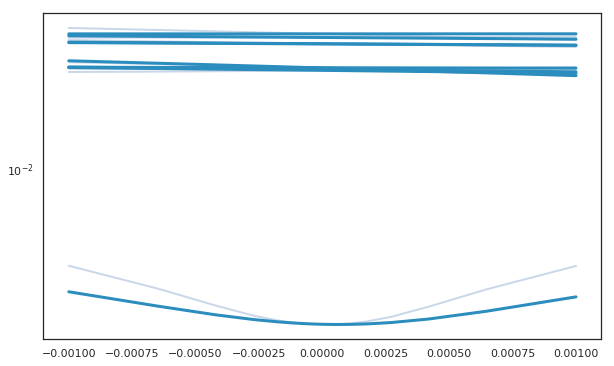

In [49]:
plt.figure(figsize=(10,6))
plt.semilogy(controls, d_norms0, linewidth = 2, alpha=.6, color='#a6bddb');
plt.semilogy(controls,d_norms1, linewidth = 3, alpha=1, color='#2b8cbe');

In [54]:
np.save('dnorms0', d_norms0)

In [55]:
np.save('dnorms1', d_norms1)

In [56]:
from time import time
start = time()
num_pts = 10
base = np.logspace(-4.7, np.log(pca.detunings[0][0])/np.log(10), num_pts)
controls = np.concatenate([np.sort(-base),np.array([0]), base])
combinations0 = [[det,0] for det in controls]

base = np.logspace(-4.7, np.log(pca.detunings[1][0])/np.log(10), num_pts)
controls = np.concatenate([np.sort(-base),np.array([0]), base])
combinations1 = [[0,det] for det in controls]

d_norms2 = []
for i in range(len(combinations0)):
    combo = combinations0[i]
    lst = [pca.controlset, pca.ambient_hamiltonian, combo, pca.dt,
            pca.control_hamiltonians, pca.target_operator, pca.probs]
    d_norms2.append(compute_diamond_norm(lst))

d_norms3 = []
for i in range(len(combinations1)):
    combo = combinations1[i]
    lst = [pca.controlset, pca.ambient_hamiltonian, combo, pca.dt,
            pca.control_hamiltonians, pca.target_operator, pca.probs]
    d_norms3.append(compute_diamond_norm(lst))
stop = time()
print(stop - start)

1072.8359298706055


In [57]:
# diamond_norms = np.array([rc[i]['d_norms'] for i in range(20)])
# controls = np.array([rc[i]['combo'][0] for i in range(20)])
#diamond_norms = np.array(d_norms0)
controls = np.array(controls)

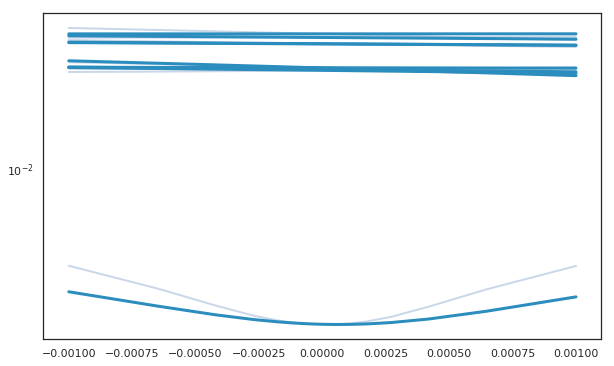

In [58]:
plt.figure(figsize=(10,6))
plt.semilogy(controls, d_norms0, linewidth = 2, alpha=.6, color='#a6bddb');
plt.semilogy(controls,d_norms1, linewidth = 3, alpha=1, color='#2b8cbe');

In [59]:
np.save('dnorms2', d_norms2)

In [60]:
np.save('dnorms3', d_norms3)

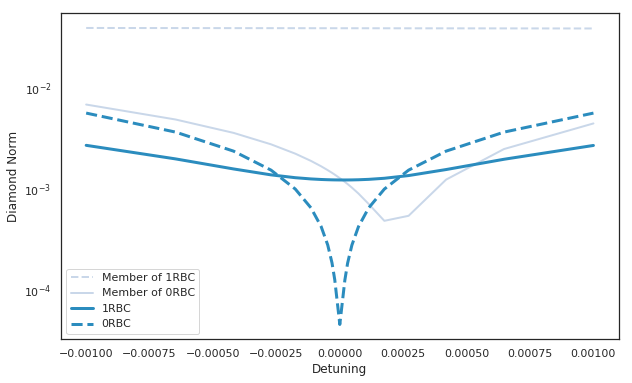

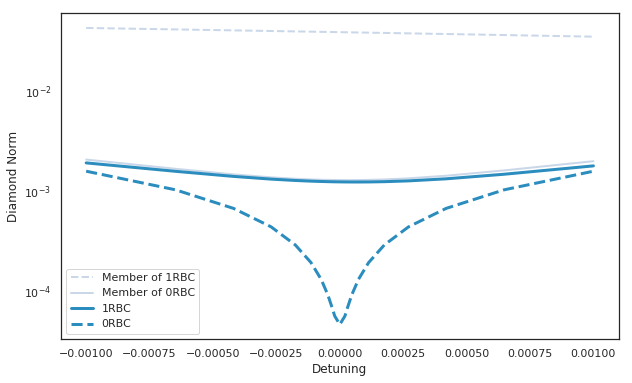

In [118]:
for a, b in ((d_norms0, d_norms2), (d_norms1, d_norms3)):
    plt.figure(figsize=(10,6))
    plt.semilogy(controls, np.array(a).T[7], linewidth = 2, alpha=.6, color='#a6bddb', label="Member of 1RBC", ls="--");
    plt.semilogy(controls, np.array(b).T[7], linewidth = 2, alpha=.6, color='#a6bddb', label="Member of 0RBC", ls="-");


    plt.semilogy(controls, np.array(a).T[-1], linewidth = 3, alpha=1, color='#2b8cbe', label="1RBC", ls="-");
    plt.semilogy(controls,np.array(b).T[-1], linewidth = 3, alpha=1, color='#2b8cbe', label="0RBC", ls="--");
    plt.ylabel("Diamond Norm")
    plt.xlabel("Detuning")
    plt.legend()

array([[0.03898629, 0.03876514, 0.03866952, 0.0386277 , 0.03860908,
        0.03860057, 0.03859655, 0.03859457, 0.03859355, 0.038593  ,
        0.03859221, 0.03859171, 0.03859156, 0.0385915 , 0.03859181,
        0.03859325, 0.03859777, 0.03861023, 0.03864255, 0.03872357,
        0.03892239],
       [0.03726498, 0.03746257, 0.03764653, 0.03778875, 0.03789039,
        0.03796017, 0.03800699, 0.03803799, 0.03805835, 0.03807165,
        0.0380963 , 0.03812128, 0.03813502, 0.03815643, 0.03818996,
        0.0382428 , 0.03832694, 0.03846285, 0.03868681, 0.03906556,
        0.03972644],
       [0.05733566, 0.05632794, 0.05569995, 0.05530401, 0.05505224,
        0.05489119, 0.05478776, 0.05472115, 0.05467818, 0.05465042,
        0.0545996 , 0.05454895, 0.05452142, 0.05447898, 0.05441364,
        0.05431325, 0.05415946, 0.05392501, 0.0535704 , 0.05304107,
        0.05226886],
       [0.05625465, 0.0555591 , 0.05513946, 0.05488096, 0.05471922,
        0.05461689, 0.05455165, 0.05450983, 0.0544829

In [61]:
for i, row in enumerate(d_norms[:-1, :]):
    reordered_row = np.array([row[j] for j in indices])
    plt.plot(range(len(row)), reordered_row)
plt.plot(range(len(d_norms[-1, :])), [d_norms[-1, :][i] for i in indices], label="min", color='k', linewidth=2, zorder=10)
plt.legend()
plt.ylabel("Diamond Distance")
plt.semilogy()
plt.xlabel("Sample Index")
plt.tight_layout()
plt.show()


NameError: name 'd_norms' is not defined